<a href="https://colab.research.google.com/github/ryzwann/Klasifikasi-Image-Multilabe-_MobileNetv2/blob/main/Tugas3_Multilabel_Classification_MobileNetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
import keras
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import os
os.environ["KAGGLE_USERNAME"] = "muhammadrizwandarwis"
os.environ["KAGGLE_KEY"] = "9e4a9ddf0509d6a22630d1228136ed67"

In [4]:
!kaggle datasets download -d datasetmultilabel-Muhammad-Rizwan-202255202085

Dataset URL: https://www.kaggle.com/datasets/muhammadrizwandarwis/datasetmultilabel-Muhammad-Rizwan-202255202085
License(s): other


In [5]:
# prompt: unzip file movie-classifier.zip

!!unzip -o datasetmultilabel-Muhammad-Rizwan-202255202085.zip -d dataset


['Archive:  datasetmultilabel-Muhammad-Rizwan-202255202085.zip',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar001.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar002.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar003.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar004.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar005.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar006.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar007.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar008.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar009.jpg  ',
 '  inflating: dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar010.jpg

In [6]:
# ✅ Upload file dari komputer
from google.colab import files
import pandas as pd

uploaded = files.upload()  # Pilih file: .csv atau .xlsx

# ✅ Ambil nama file yang diupload
filename = list(uploaded.keys())[0]

# ✅ Baca file sesuai jenisnya
if filename.endswith('.csv'):
    df = pd.read_csv(filename)
elif filename.endswith('.xlsx'):
    df = pd.read_excel(filename)
else:
    raise ValueError("File harus bertipe .csv atau .xlsx")

# ✅ Tampilkan 5 baris pertama
print(f"Berhasil membaca file: {filename}")
df.head()


Saving traindataset_Muhammad_Rizwan_Darwis_202255202085.csv to traindataset_Muhammad_Rizwan_Darwis_202255202085.csv
Berhasil membaca file: traindataset_Muhammad_Rizwan_Darwis_202255202085.csv


,Id,Object,Buku,Sepatu,Gelas,Sendok Nasi
0,Gambar001,"['Buku, 'Sepatu']",1,1,0,0
1,Gambar002,"['Buku', 'Sepatu', 'Gelas', 'Sendok Nasi']",1,1,1,1
2,Gambar003,"['Buku', 'Sepatu', 'Gelas', 'Sendok Nasi']",1,1,1,1
3,Gambar004,"['Buku', 'Sepatu', 'Gelas']",1,1,1,0
4,Gambar005,"['Buku', 'Sepatu',]",1,1,0,0


In [8]:
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
import numpy as np
import os

SIZE = 224
X_dataset = []

# ✅ Ganti ke path yang benar sesuai folder kamu
image_directory = '/content/dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085'

not_found = []

for i in tqdm(range(df.shape[0])):
    img_name = df['Id'][i] + '.jpg'
    img_path = os.path.join(image_directory, img_name)

    if not os.path.exists(img_path):
        not_found.append(img_name)
        print(f"❌ File tidak ditemukan: {img_name}")
        continue

    img = image.load_img(img_path, target_size=(SIZE, SIZE, 3))
    img = image.img_to_array(img)
    img = img / 255.
    X_dataset.append(img)

X = np.array(X_dataset)
print(f"\n✅ Jumlah gambar berhasil diproses: {len(X)}")
print(f"❗ Jumlah gambar hilang: {len(not_found)}")


100%|██████████| 300/300 [00:23<00:00, 13.01it/s]


✅ Jumlah gambar berhasil diproses: 300
❗ Jumlah gambar hilang: 0


In [10]:
#
print(df['Id'][250])

Gambar251


In [12]:
print(df['Object'][250])  #Tagged as multiple Object.

['Buku, 'Sepatu']


In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

# Drop kolom yang bukan label
y = np.array(df.drop(['Id', 'Object'], axis=1))

# Split dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)


In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Ganti SIZE dengan ukuran input gambar
SIZE = 224

# Load MobileNetV2 tanpa top classifier
base_model = MobileNetV2(input_shape=(SIZE, SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Tambahkan layer klasifikasi di atas MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='sigmoid')(x)  # 4 label untuk multilabel

# Bangun model akhir
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,430,468 (9.27 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
from tensorflow.keras.metrics import AUC

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

In [16]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - auc: 0.6474 - loss: 0.7731 - val_auc: 0.9093 - val_loss: 0.3226
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - auc: 0.8107 - loss: 0.5207 - val_auc: 0.9251 - val_loss: 0.3032
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - auc: 0.8580 - loss: 0.4391 - val_auc: 0.9227 - val_loss: 0.2967
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8813 - loss: 0.3812 - val_auc: 0.9268 - val_loss: 0.2908
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.9219 - loss: 0.3223 - val_auc: 0.9353 - val_loss: 0.2679
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - auc: 0.9101 - loss: 0.3378 - val_auc: 0.9480 - val_loss: 0.2515
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - auc: 0.9158 - loss: 0.3272 - val_auc: 0.9608 - val_loss: 0.2432
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.9401 - loss: 0.2849 - val_auc: 0.9592 - val_loss: 0.2300
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - auc: 0.9451 - loss: 0.2667 - 

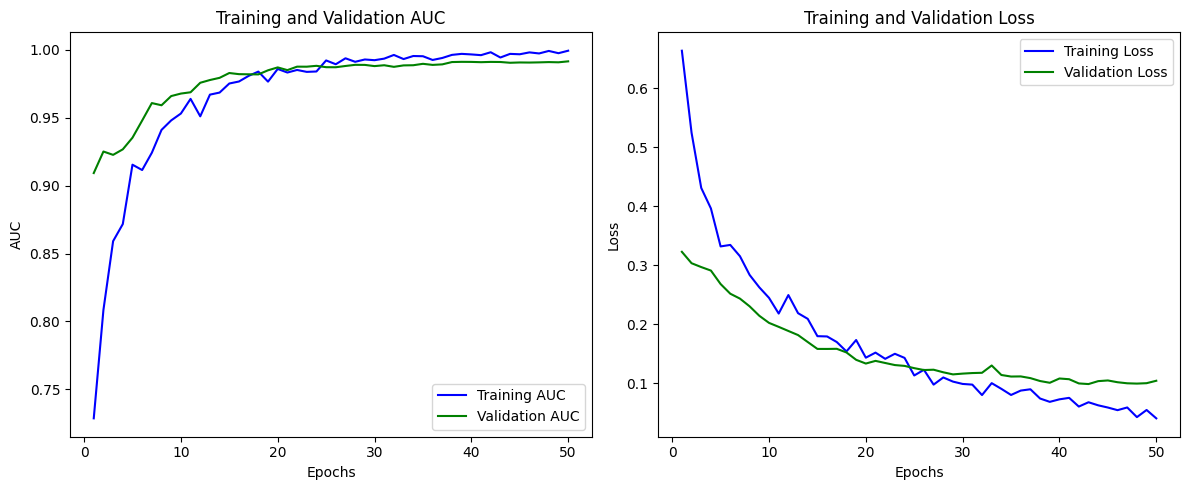

In [17]:
import matplotlib.pyplot as plt

# Ambil nilai AUC dan Loss dari riwayat training
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(auc) + 1)

# Plot AUC
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, auc, 'b', label='Training AUC')
plt.plot(epochs, val_auc, 'g', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


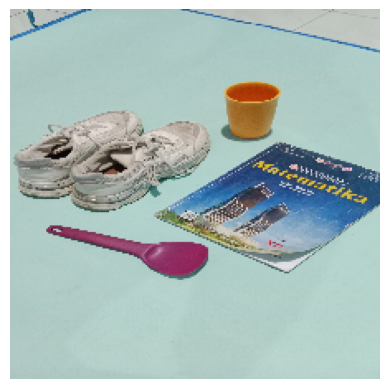

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sepatu: 1.0000
Buku: 0.9999
Gelas: 0.9999
Sendok Nasi: 0.9859


In [21]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Path dan ukuran
SIZE = 224
img_path = '/content/dataset/DatasetMultilabe_Muhammad Rizwan Darwis_202255202085/Gambar185.jpg'

# Load dan praproses gambar
img = image.load_img(img_path, target_size=(SIZE, SIZE, 3))
img_array = image.img_to_array(img) / 255.
plt.imshow(img_array)
plt.axis('off')
plt.show()

# Siapkan untuk prediksi
img_input = np.expand_dims(img_array, axis=0)
classes = np.array(df.columns[2:])  # Ambil nama label dari kolom
proba = model.predict(img_input)
sorted_categories = np.argsort(proba[0])[::-1]

# Tampilkan hasil prediksi
for i in sorted_categories:
    print(f"{classes[i]}: {proba[0][i]:.4f}")


In [22]:
#Print classes and corresponding probabilities
for i in range(4):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

Sepatu (1.0)
Buku (1.0)
Gelas (1.0)
Sendok Nasi (0.986)


In [23]:
###################################################

loss, auc = model.evaluate(X_test, y_test)
print("AUC = ", (auc * 100.0), "%")

###################################################

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.9917 - loss: 0.1041
AUC =  99.15665984153748 %


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
              precision    recall  f1-score   support

        Buku       1.00      1.00      1.00        90
      Sepatu       1.00      1.00      1.00        90
       Gelas       0.97      1.00      0.99        67
 Sendok Nasi       0.69      0.97      0.81        35

   micro avg       0.94      1.00      0.97       282
   macro avg       0.92      0.99      0.95       282
weighted avg       0.96      1.00      0.97       282
 samples avg       0.95      1.00      0.97       282



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


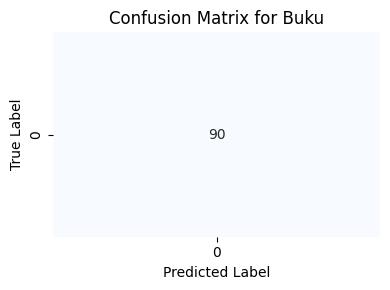

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


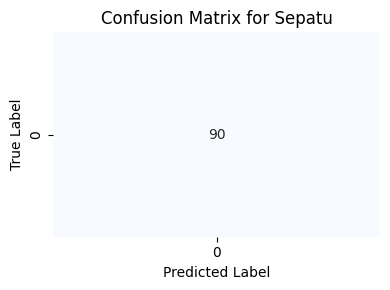

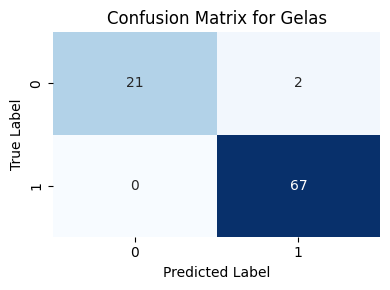

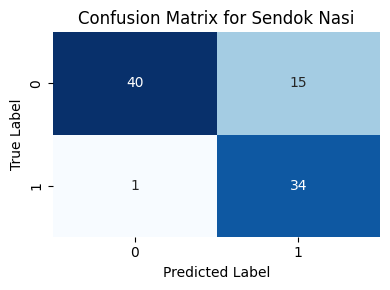

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Laporan klasifikasi
print(classification_report(y_test, y_pred_classes, target_names=classes))

# Visualisasi confusion matrix
for i in range(len(classes)):
    cm = confusion_matrix(y_test[:, i], y_pred_classes[:, i])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {classes[i]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
